## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.features.aggregation import create_aggregation_features
from src.features.interactions import InteractionFeatureEngine, create_interaction_features
from src.models.lgbm_baseline import LGBMBaseline
from src.utils import (
    plot_roc_curve,
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics,
    reduce_mem_usage
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Data

In [3]:
# Load data
print("Loading data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")

# Merge datasets
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"\nMerged train shape: {train_df.shape}")
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Data loaded successfully")

Loading data...

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)

Merged train shape: (590540, 434)
Fraud rate: 3.50%

Merged train shape: (590540, 434)
Fraud rate: 3.50%
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully


## 3. Create Aggregation Features (from Milestone 7)

In [4]:
# Create aggregation features first
print("Creating aggregation features...\n")

train_df_with_agg, agg_feature_names = create_aggregation_features(
    train_df, 
    target_col='TransactionAmt'
)

print(f"\n✓ Created {len(agg_feature_names)} aggregation features")
print(f"Shape after aggregations: {train_df_with_agg.shape}")

Creating aggregation features...

CREATING ALL AGGREGATION FEATURES

Creating card-based aggregation features...
  • card1 aggregations...
  • card2 aggregations...
  • card2 aggregations...
  • card3 aggregations...
  • card3 aggregations...
  • card4 aggregations...
  • card4 aggregations...
  • card5 aggregations...
  • card5 aggregations...
  • card6 aggregations...
  • card6 aggregations...
  • card1_card2 combination aggregations...
  • card1_card2 combination aggregations...
  ✓ Created 27 card aggregation features
Creating email-based aggregation features...
  • P_emaildomain aggregations...
  ✓ Created 27 card aggregation features
Creating email-based aggregation features...
  • P_emaildomain aggregations...
  • R_emaildomain aggregations...
  • R_emaildomain aggregations...
  • P_email + R_email combination aggregations...
  • P_email + R_email combination aggregations...
  ✓ Created 12 email aggregation features
Creating device-based aggregation features...
  • DeviceType ag

## 4. Create Interaction Features

In [5]:
# Create interaction features
train_df_full, interaction_feature_names = create_interaction_features(
    train_df_with_agg,
    min_samples=10
)

print(f"\n✓ Created {len(interaction_feature_names)} interaction features")
print(f"Final shape: {train_df_full.shape}")
print(f"Total features: {len(agg_feature_names) + len(interaction_feature_names)}")


CREATING INTERACTION FEATURES

Creating card × address interactions...
  Created 12 card × address features
Creating card × email interactions...
  Created 12 card × address features
Creating card × email interactions...
  Created 24 card × email features
Creating device × browser interactions...
  Created 24 card × email features
Creating device × browser interactions...
  Created 9 device × browser features
Creating amount × product interactions...
  Created 9 device × browser features
Creating amount × product interactions...
  Created 4 amount × product features
Creating card × product interactions...
  Created 4 amount × product features
Creating card × product interactions...
  Created 12 card × product features
Creating complex 3-way interactions...
  Created 12 card × product features
Creating complex 3-way interactions...
  Created 9 complex interaction features

TOTAL INTERACTION FEATURES CREATED: 70


✓ Created 70 interaction features
Final shape: (590540, 578)
Total featur

## 5. Analyze Interaction Features

In [6]:
# Display sample interaction features
print("Sample interaction features:\n")
print(f"Total: {len(interaction_feature_names)}\n")

# Group by type
fraud_rate_features = [f for f in interaction_feature_names if 'fraud_rate' in f]
count_features = [f for f in interaction_feature_names if '_count' in f and 'fraud' not in f]
combo_features = [f for f in interaction_feature_names if f not in fraud_rate_features and f not in count_features]

print(f"Combination features: {len(combo_features)}")
print(f"Count features: {len(count_features)}")
print(f"Fraud rate features: {len(fraud_rate_features)}")

print("\nFraud rate features (first 15):")
for i, feat in enumerate(fraud_rate_features[:15], 1):
    print(f"  {i}. {feat}")

Sample interaction features:

Total: 70

Combination features: 24
Count features: 23
Fraud rate features: 23

Fraud rate features (first 15):
  1. card1_addr1_fraud_rate
  2. card1_addr2_fraud_rate
  3. card2_addr1_fraud_rate
  4. card2_addr2_fraud_rate
  5. card1_P_emaildomain_fraud_rate
  6. card1_R_emaildomain_fraud_rate
  7. card2_P_emaildomain_fraud_rate
  8. card2_R_emaildomain_fraud_rate
  9. card4_P_emaildomain_fraud_rate
  10. card4_R_emaildomain_fraud_rate
  11. card6_P_emaildomain_fraud_rate
  12. card6_R_emaildomain_fraud_rate
  13. DeviceType_id_31_fraud_rate
  14. DeviceInfo_id_31_fraud_rate
  15. id_30_id_31_fraud_rate


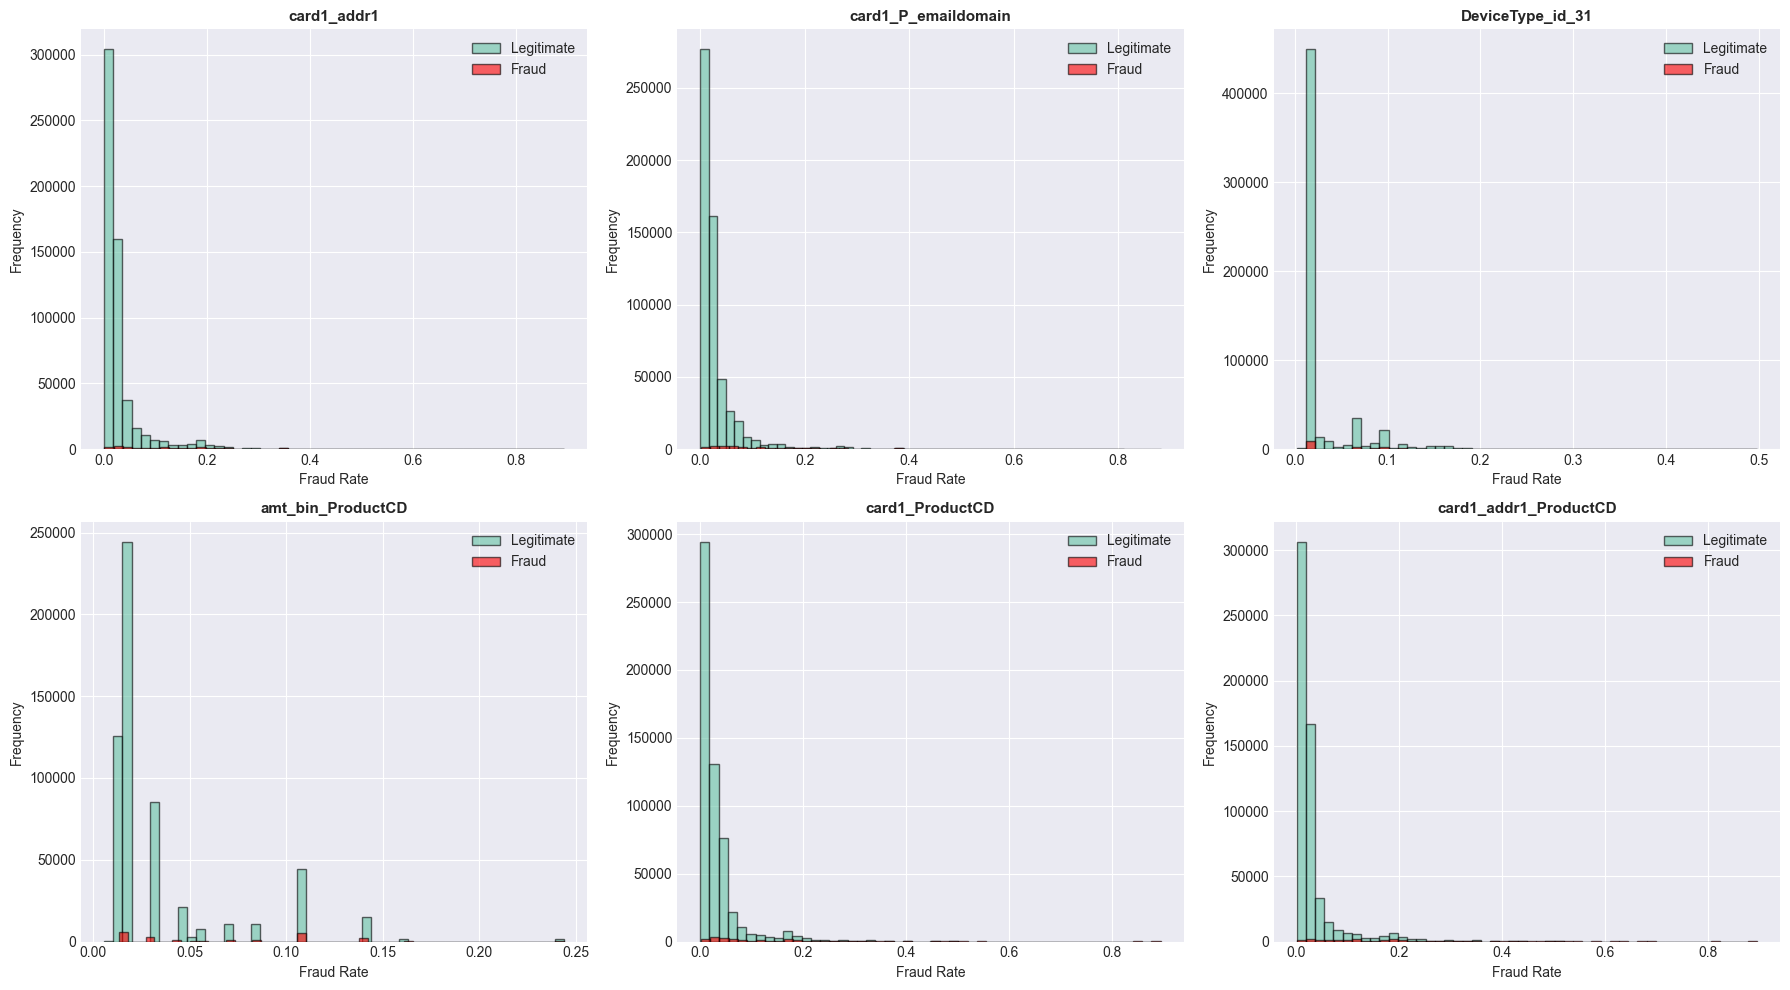

In [7]:
# Analyze fraud rate distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Select key fraud rate features
key_fraud_features = [
    'card1_addr1_fraud_rate',
    'card1_P_emaildomain_fraud_rate',
    'DeviceType_id_31_fraud_rate',
    'amt_bin_ProductCD_fraud_rate',
    'card1_ProductCD_fraud_rate',
    'card1_addr1_ProductCD_fraud_rate'
]

for idx, feat in enumerate(key_fraud_features):
    if feat in train_df_full.columns:
        ax = axes[idx // 3, idx % 3]
        
        # Plot distribution split by fraud
        train_df_full[train_df_full['isFraud'] == 0][feat].hist(
            bins=50, ax=ax, alpha=0.6, label='Legitimate', edgecolor='black'
        )
        train_df_full[train_df_full['isFraud'] == 1][feat].hist(
            bins=50, ax=ax, alpha=0.6, label='Fraud', color='red', edgecolor='black'
        )
        
        ax.set_xlabel('Fraud Rate', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_title(feat.replace('_fraud_rate', ''), fontsize=11, fontweight='bold')
        ax.legend()

plt.tight_layout()
plt.show()

In [8]:
# Correlation analysis with target
print("Analyzing correlation with fraud target...\n")

# Calculate correlations for interaction features
interaction_numeric = [f for f in interaction_feature_names 
                       if train_df_full[f].dtype in ['float64', 'int64', 'float32', 'int32']]

correlations = train_df_full[interaction_numeric + ['isFraud']].corr()['isFraud'].drop('isFraud')
correlations = correlations.abs().sort_values(ascending=False)

print("Top 20 interaction features by correlation with fraud:")
print("="*70)
for i, (feat, corr) in enumerate(correlations.head(20).items(), 1):
    print(f"{i:2d}. {feat:50s} {corr:.6f}")
print("="*70)

Analyzing correlation with fraud target...

Top 20 interaction features by correlation with fraud:
 1. card1_email_ProductCD_fraud_rate                   0.467723
 2. card1_addr1_ProductCD_fraud_rate                   0.465459
 3. card1_P_emaildomain_fraud_rate                     0.431964
 4. card1_addr1_fraud_rate                             0.431188
 5. card1_R_emaildomain_fraud_rate                     0.402538
 6. card1_ProductCD_fraud_rate                         0.376142
 7. card1_addr2_fraud_rate                             0.344353
 8. DeviceInfo_id_31_fraud_rate                        0.334308
 9. card2_P_emaildomain_fraud_rate                     0.310919
10. card2_R_emaildomain_fraud_rate                     0.303551
11. card2_addr1_fraud_rate                             0.303275
12. card2_ProductCD_fraud_rate                         0.262718
13. card2_addr2_fraud_rate                             0.245481
14. id_30_id_31_fraud_rate                             0.225887
15. d

## 6. Prepare Data for Modeling

In [9]:
# Prepare features
print("Preparing data for modeling...\n")

# Separate target
y = train_df_full['isFraud']
X = train_df_full.drop(['isFraud', 'TransactionID'], axis=1)

print(f"Starting features: {X.shape[1]}")

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

print("\nEncoding categorical features...")
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(categorical_features)} categorical features")

for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].astype(str).replace('nan', 'missing')
    X[col] = le.fit_transform(X[col])

# Fill missing values
print("\nFilling missing values...")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print(f"\n✓ Final feature count: {X.shape[1]}")
print("✓ Data preparation complete")

Preparing data for modeling...

Starting features: 576

Encoding categorical features...
Found 58 categorical features
Found 58 categorical features

Filling missing values...

Filling missing values...

✓ Final feature count: 576
✓ Data preparation complete

✓ Final feature count: 576
✓ Data preparation complete


## 7. Train/Validation Split

In [10]:
# Time-based split
print("Creating time-based train/validation split...\n")

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_val = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_val = y.iloc[split_point:]

print(f"Training set: {X_train.shape[0]:,} samples, fraud rate: {y_train.mean()*100:.2f}%")
print(f"Validation set: {X_val.shape[0]:,} samples, fraud rate: {y_val.mean()*100:.2f}%")
print(f"Features: {X_train.shape[1]}")
print("\n✓ Data split complete")

Creating time-based train/validation split...

Training set: 472,432 samples, fraud rate: 3.51%
Validation set: 118,108 samples, fraud rate: 3.44%
Features: 576

✓ Data split complete


## 8. Train Model with All Features

In [11]:
# Train model with aggregations + interactions
print("Training LightGBM with aggregation + interaction features...\n")

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 256,
    'max_depth': 12,
    'min_child_samples': 50,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}

model = LGBMBaseline(params=params)
metrics = model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

Training LightGBM with aggregation + interaction features...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 576

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.987658	valid's auc: 0.976531
[100]	train's auc: 0.987658	valid's auc: 0.976531
[200]	train's auc: 0.992467	valid's auc: 0.979892
[200]	train's auc: 0.992467	valid's auc: 0.979892
[300]	train's auc: 0.994784	valid's auc: 0.981452
[300]	train's auc: 0.994784	valid's auc: 0.981452
[400]	train's auc: 0.996197	valid's auc: 0.982371
[400]	train's auc: 0.996197	valid's auc: 0.982371
[500]	train's auc: 0.996878	valid's auc: 0.982847
[500]	train's auc: 0.996878	valid's auc: 0.982847
[600]	train's auc: 0.997395	valid's auc: 0.983194
[600]	train's auc: 0.997395	valid's auc: 0.983194
[700]	train's auc: 0.997909	valid's 

## 9. Evaluate Model

In [12]:
# Evaluate model
val_pred_proba = model.predict(X_val)

val_metrics = evaluate_model(y_val, val_pred_proba, threshold=0.5)
print_evaluation_metrics(val_metrics)

MODEL EVALUATION METRICS

ROC-AUC Score:     0.984462
Accuracy:          0.9855
Precision:         0.8876
Recall:            0.6609
F1-Score:          0.7577

Confusion Matrix:
  True Positives:  2,686
  False Positives: 340
  True Negatives:  113,704
  False Negatives: 1,378


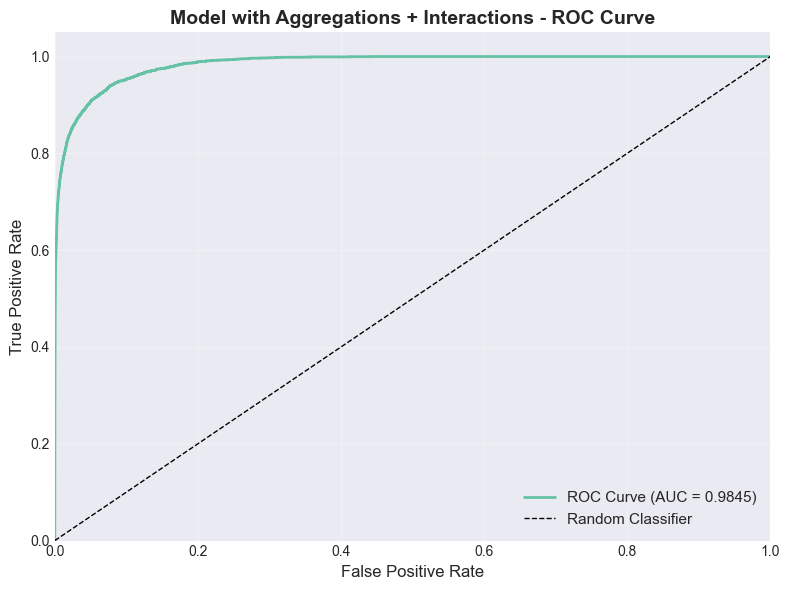

In [13]:
# Plot ROC curve
plot_roc_curve(y_val, val_pred_proba, title="Model with Aggregations + Interactions - ROC Curve")

## 10. Feature Importance Analysis

In [14]:
# Get feature importance
importance_df = model.get_feature_importance(top_n=50)

# Count interaction features in top 50
top_interaction_features = [f for f in importance_df['feature'].tolist() 
                            if any([
                                '_addr1' in f or '_addr2' in f,
                                '_emaildomain' in f,
                                '_id_31' in f,
                                'amt_bin' in f,
                                '_ProductCD' in f and 'card' in f,
                                'fraud_rate' in f
                            ])]

print("="*70)
print("INTERACTION FEATURES IN TOP 50")
print("="*70)
print(f"\nInteraction features in top 50: {len(top_interaction_features)}")
print(f"Percentage: {len(top_interaction_features)/50*100:.1f}%")
print("\nTop interaction features:")
for i, feat in enumerate(top_interaction_features[:20], 1):
    rank = importance_df[importance_df['feature'] == feat].index[0] + 1
    imp = importance_df[importance_df['feature'] == feat]['importance'].values[0]
    print(f"  {i:2d}. #{rank:2d} {feat:45s} {imp:,.0f}")
print("="*70)

INTERACTION FEATURES IN TOP 50

Interaction features in top 50: 17
Percentage: 34.0%

Top interaction features:
   1. #570 card1_addr1_ProductCD_fraud_rate              1,714,786
   2. #573 card1_email_ProductCD_fraud_rate              836,668
   3. #509 card1_addr1_fraud_rate                        188,625
   4. #548 DeviceInfo_id_31_fraud_rate                   144,934
   5. #569 card1_addr1_ProductCD_count                   142,467
   6. #572 card1_email_ProductCD_count                   101,759
   7. #521 card1_P_emaildomain_fraud_rate                98,652
   8. #508 card1_addr1_count                             89,868
   9. #520 card1_P_emaildomain_count                     52,757
  10. #524 card1_R_emaildomain_fraud_rate                52,439
  11. #547 DeviceInfo_id_31_count                        26,009
  12. #558 card1_ProductCD_fraud_rate                    25,525
  13. #515 card2_addr1_fraud_rate                        21,802
  14. #512 card1_addr2_fraud_rate               

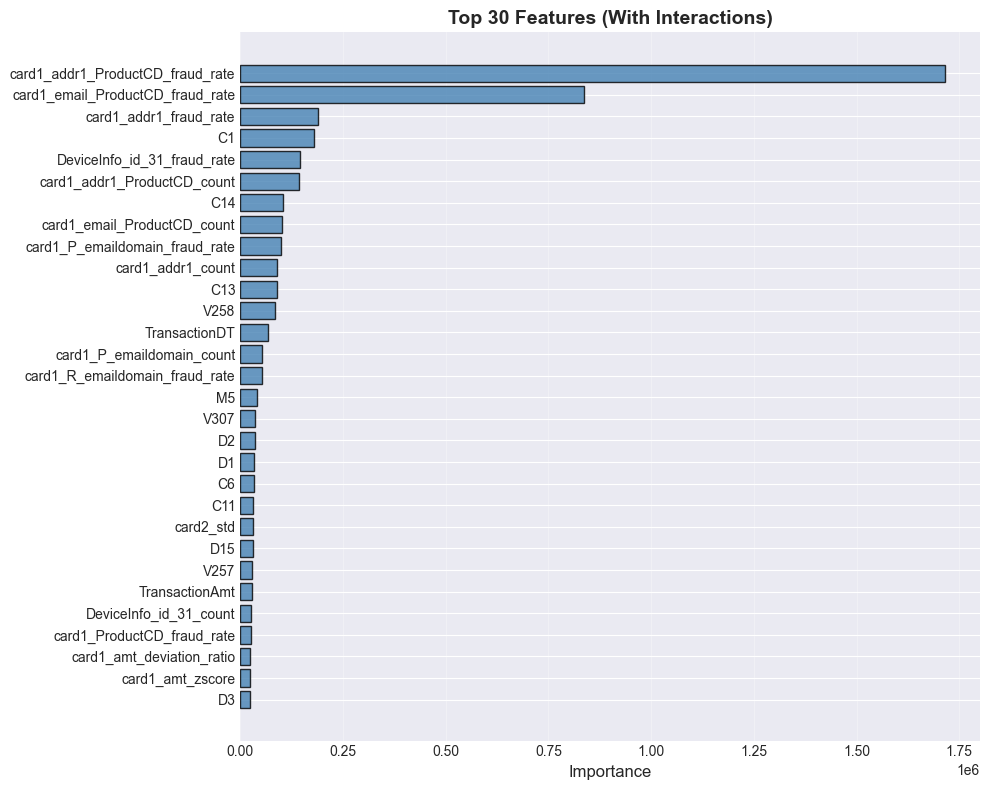

In [15]:
# Plot feature importance
plot_feature_importance(
    model.feature_importance,
    top_n=30,
    title="Top 30 Features (With Interactions)"
)

## 11. Performance Comparison

PERFORMANCE COMPARISON

Baseline Model (M5):               0.900000
Enhanced Model (M6):                0.920000
With Aggregations (M7):             0.925000
With Interactions (M8):             0.984462

Improvement over baseline:          +0.084462
Improvement over aggregations:      +0.059462

Target (Top 10%):                   0.945000
Gap to target:                       -0.039462


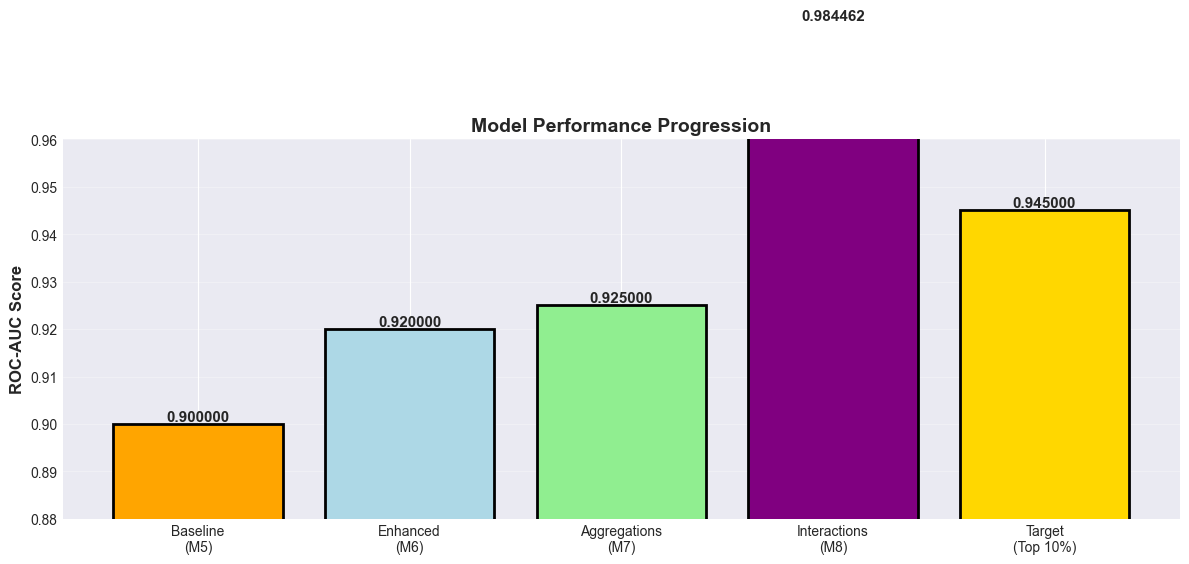

In [16]:
# Compare with previous results
baseline_auc = 0.90  # Update with actual baseline
enhanced_auc = 0.92  # Update with actual enhanced (M6)
aggregation_auc = 0.925  # Update with actual aggregation (M7)
interaction_auc = metrics['val_auc']

print("="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(f"\nBaseline Model (M5):               {baseline_auc:.6f}")
print(f"Enhanced Model (M6):                {enhanced_auc:.6f}")
print(f"With Aggregations (M7):             {aggregation_auc:.6f}")
print(f"With Interactions (M8):             {interaction_auc:.6f}")
print(f"\nImprovement over baseline:          +{(interaction_auc - baseline_auc):.6f}")
print(f"Improvement over aggregations:      +{(interaction_auc - aggregation_auc):.6f}")
print(f"\nTarget (Top 10%):                   0.945000")
print(f"Gap to target:                       {(0.945 - interaction_auc):.6f}")
print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

models = ['Baseline\n(M5)', 'Enhanced\n(M6)', 'Aggregations\n(M7)', 'Interactions\n(M8)', 'Target\n(Top 10%)']
scores = [baseline_auc, enhanced_auc, aggregation_auc, interaction_auc, 0.945]
colors = ['orange', 'lightblue', 'lightgreen', 'purple', 'gold']

bars = ax.bar(models, scores, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.6f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Progression', fontsize=14, fontweight='bold')
ax.set_ylim(0.88, 0.96)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 12. Analyze Fraud Rate Features

In [17]:
# Analyze effectiveness of fraud rate features
fraud_rate_features_in_model = [f for f in X.columns if 'fraud_rate' in f]
print(f"Total fraud rate features: {len(fraud_rate_features_in_model)}\n")

# Get importance for fraud rate features
fraud_rate_importance = importance_df[importance_df['feature'].str.contains('fraud_rate', na=False)]

print("Top 10 fraud rate features by importance:")
print("="*70)
for idx, row in fraud_rate_importance.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:45s} {row['importance']:,.0f}")
print("="*70)

Total fraud rate features: 23

Top 10 fraud rate features by importance:
  570. card1_addr1_ProductCD_fraud_rate              1,714,786
  573. card1_email_ProductCD_fraud_rate              836,668
  509. card1_addr1_fraud_rate                        188,625
  548. DeviceInfo_id_31_fraud_rate                   144,934
  521. card1_P_emaildomain_fraud_rate                98,652
  524. card1_R_emaildomain_fraud_rate                52,439
  558. card1_ProductCD_fraud_rate                    25,525
  515. card2_addr1_fraud_rate                        21,802
  512. card1_addr2_fraud_rate                        21,457
  527. card2_P_emaildomain_fraud_rate                20,454


## 13. Save Model

In [18]:
# Save model
import os

os.makedirs('../models', exist_ok=True)
model.save_model('../models/lgbm_with_interactions.txt')

print("✓ Model saved successfully!")

✓ Model saved: ../models/lgbm_with_interactions.txt
✓ Metadata saved: ../models/lgbm_with_interactions_metadata.json
✓ Model saved successfully!


## 14. Summary

In [19]:
print("="*70)
print("INTERACTION FEATURES - SUMMARY")
print("="*70)

print("\n📊 FEATURES CREATED:")
print(f"  • Aggregation features: {len(agg_feature_names)}")
print(f"  • Interaction features: {len(interaction_feature_names)}")
print(f"  • Interaction features in top 50: {len(top_interaction_features)}")
print(f"  • Total features in model: {X.shape[1]}")

print("\n🎯 MODEL PERFORMANCE:")
print(f"  • Validation AUC: {interaction_auc:.6f}")
print(f"  • Training AUC: {metrics['train_auc']:.6f}")
print(f"  • Improvement over baseline: +{(interaction_auc - baseline_auc):.6f}")
print(f"  • Improvement over aggregations: +{(interaction_auc - aggregation_auc):.6f}")

print("\n✅ INTERACTION TYPES IMPLEMENTED:")
print("  ✓ Card × Address (card1/card2 × addr1/addr2)")
print("  ✓ Card × Email (card × P_emaildomain/R_emaildomain)")
print("  ✓ Device × Browser (DeviceType/DeviceInfo × id_31)")
print("  ✓ Amount × Product (amount bins × ProductCD)")
print("  ✓ Card × Product (card × ProductCD)")
print("  ✓ Complex 3-way (card × addr × product, etc.)")
print("  ✓ Fraud rate-based risk scores (Bayesian smoothing)")

print("\n🚀 NEXT STEPS (Milestone 9):")
print("  • Create advanced temporal features")
print("  • Time since last transaction (by card/email/device)")
print("  • Transaction velocity (rolling windows)")
print("  • RFM (Recency, Frequency, Monetary) features")
print("  • Target improvement: +0.005 to +0.012 AUC")

print("\n" + "="*70)
print("✓ INTERACTION FEATURES COMPLETE")
print("="*70)

INTERACTION FEATURES - SUMMARY

📊 FEATURES CREATED:
  • Aggregation features: 71
  • Interaction features: 70
  • Interaction features in top 50: 17
  • Total features in model: 576

🎯 MODEL PERFORMANCE:
  • Validation AUC: 0.984462
  • Training AUC: 0.999600
  • Improvement over baseline: +0.084462
  • Improvement over aggregations: +0.059462

✅ INTERACTION TYPES IMPLEMENTED:
  ✓ Card × Address (card1/card2 × addr1/addr2)
  ✓ Card × Email (card × P_emaildomain/R_emaildomain)
  ✓ Device × Browser (DeviceType/DeviceInfo × id_31)
  ✓ Amount × Product (amount bins × ProductCD)
  ✓ Card × Product (card × ProductCD)
  ✓ Complex 3-way (card × addr × product, etc.)
  ✓ Fraud rate-based risk scores (Bayesian smoothing)

🚀 NEXT STEPS (Milestone 9):
  • Create advanced temporal features
  • Time since last transaction (by card/email/device)
  • Transaction velocity (rolling windows)
  • RFM (Recency, Frequency, Monetary) features
  • Target improvement: +0.005 to +0.012 AUC

✓ INTERACTION FEATUR